## Age and Ethnicity GAN
### GANs with and without distribution
#### Diana and David

In [1]:
# bring in modules

import seaborn as sns
import matplotlib.pyplot as plt

import sys
import numpy as np
import tensorflow.keras as keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Dense, Activation, LeakyReLU, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
import matplotlib.pyplot as plt
import pandas as pd
import os

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf

import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', None)

In [2]:
#from google.colab import drive # for connecting to my Google Drive
#drive.mount('/content/drive')

In [3]:
# help with code: https://keras.io/examples/generative/conditional_gan/#interpolating-between-classes-with-the-trained-generator

In [4]:
class ConditionalGAN(keras.Model):
    def __init__(self, noise_dim=50, 
                 data_shape=1,
                 num_classes=3, 
                 d_learning_rate=1e-5, 
                 g_learning_rate=1e-6, 
                 batch_size=64, 
                 start_epoch=0,
                 verbose = False, distribute = False):

        super(ConditionalGAN, self).__init__()
        self.noise_dim = noise_dim
        self.data_shape = data_shape # output shape of the generator and goes to discriminator
        self.num_classes = num_classes
        self.d_optimizer = tf.keras.optimizers.Adam(d_learning_rate)
        self.g_optimizer = tf.keras.optimizers.Adam(g_learning_rate)
        self.batch_size = batch_size
        self.start_epoch = start_epoch
        self.verbose = verbose
        self.distribute = distribute

        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

        # add number of class labels to the input channels for generator
        self.g_dim = self.noise_dim + self.num_classes

        # add the number of class labels to the input to the discriminator
        self.d_dim = self.data_shape + self.num_classes

        if (self.verbose):
            print("Generator input dim: ", self.g_dim)
            print("Dicrimination input dim: ", self.d_dim)


        # build generator and discriminator
        self.discriminator = self.build_discriminator()
        self.generator = self.build_generator()

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]
    
    def build_generator(self):
        "Build the generator model"
        inputs = Input(shape=(self.g_dim,))
        hidden = Dense(64)(inputs) # 128
        hidden = LeakyReLU(alpha=0.2)(hidden)
        hidden = BatchNormalization()(hidden)
        hidden = Dense(64)(hidden)
        hidden = LeakyReLU(alpha=0.2)(hidden)

        output = Dense(self.data_shape, activation="sigmoid")(hidden)
        #output = Dense(self.data_shape, activation="linear")(hidden)
        
        if self.distribute == False: 
          generator = Model(inputs=inputs, outputs=output, name="generator")

        elif self.distribute == 'G' or self.distribute.lower() == 'both':
          mirrored_strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() #tf.distribute.MirroredStrategy()
          with mirrored_strategy.scope():

            generator = Model(inputs=inputs, outputs=output, name="generator")
            print('Number of devices: {}'.format(mirrored_strategy.num_replicas_in_sync))
            
        else:
            print('Unrecognized distribution call. Reverting to non distributed GAN.')
            generator = Model(inputs=inputs, outputs=output, name="generator")

        generator.summary()
        return generator


    def build_discriminator(self):
        "build the discriminator model"
        d_inputs = Input(shape=(self.d_dim,))
        h = Dense(64, input_shape=(self.g_dim,))(d_inputs) 
        h = LeakyReLU(alpha=0.2)(h)
        h = Dropout(0.1)(h)
        h = Dense(64)(h) #32
        h = LeakyReLU(alpha=0.2)(h)
        h = Dropout(0.1)(h)
        h = Dense(1, activation="sigmoid")(h)
        
        if self.distribute == False:
          discriminator = Model(d_inputs, h, name="discriminator")

        elif self.distribute == 'D' or self.distribute.lower() == 'both':
          mirrored_strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() #tf.distribute.MirroredStrategy()
          with mirrored_strategy.scope():
            discriminator = Model(d_inputs, h, name="discriminator")
            print('Number of devices: {}'.format(mirrored_strategy.num_replicas_in_sync))
            
        else:
            print('Unrecognized distribution call. Reverting to non distributed GAN.')
            generator = Model(inputs=inputs, outputs=output, name="generator")      


        discriminator.summary()
        return discriminator

    def compile(self, loss_fn):
        super(ConditionalGAN, self).compile()
        self.loss_fn = loss_fn

    def train_step(self, data):
        # Unpack the data.
        real_ages, one_hot_labels = data
        real_ages = tf.cast(real_ages, tf.float32)
        #print("real_ages:", real_ages[0:2])

        # Add dummy dimensions to the labels so that they can be concatenated with
        # the images. This is for the discriminator.
        age_one_hot_labels = one_hot_labels[:, None]
        print("age_one_hot_labels1:", age_one_hot_labels[0:2])

        age_one_hot_labels = tf.repeat(age_one_hot_labels, repeats=[1])
        print("age_one_hot_labels2:", age_one_hot_labels[0:2])

        age_one_hot_labels = tf.reshape(age_one_hot_labels, (-1, self.num_classes))
        age_one_hot_labels = tf.cast(age_one_hot_labels, tf.float32)
        print("age_one_hot_labels3:", age_one_hot_labels[0:2])

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = tf.shape(real_ages)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.noise_dim))
        random_vector_labels = tf.concat([random_latent_vectors, one_hot_labels], axis=1)

        # Decode the noise (guided by labels) to fake ages.
        generated_ages = self.generator(random_vector_labels)
        generated_ages= tf.cast(generated_ages, tf.float32)

        # Combine them with real images. Note that we are concatenating the labels
        # with these images here. and tf.concat is on the last dimension (-1)
        fake_ages_and_labels = tf.concat([generated_ages, age_one_hot_labels], -1)
        real_ages_and_labels = tf.concat([real_ages, age_one_hot_labels], -1) 
        combined_ages = tf.concat([fake_ages_and_labels, real_ages_and_labels], axis=0)

        # Assemble labels discriminating real from fake ages. 1 == fake, 0 == real
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        # TODO: concerned that observations are ordered fake then real - do we want to concat, then shuffle, then separate?
        
        #labels = tf.random.shuffle(labels, seed = 24)

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_ages)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.t
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.noise_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Assemble labels that say "all real images".
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_ages = self.generator(random_vector_labels)
            fake_ages_and_labels = tf.concat([fake_ages, age_one_hot_labels], -1)
            predictions = self.discriminator(fake_ages_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }

    def generate(self, n=1000, one_hot_label=[1., 0., 0.]):
        """Generate n ages for a class"""
        print("Generating: ", n, " ages for unit type: ", one_hot_label)
        input_noise = tf.random.normal((n, self.noise_dim), 0, 1)
        random_vector_labels = tf.concat([input_noise, one_hot_label], axis=1)

        ages = self.generator(random_vector_labels)

        return ages.numpy()

In [5]:
import os
os.getcwd()

'/sfs/qumulo/qhome/dmf4ns/DS6050'

In [6]:
# load data
ages_ethnicity_np = np.load("/sfs/qumulo/qhome/dmf4ns/DS6050/eICU_age_ethnicity.npy", allow_pickle=True)


In [7]:
ages_ethnicity_np # check output

array([[(87,), ('Caucasian',)],
       [(87,), ('Caucasian',)],
       [(76,), ('Caucasian',)],
       ...,
       [(41,), ('African American',)],
       [(72,), ('Caucasian',)],
       [(50,), ('Caucasian',)]], dtype=object)

In [8]:
ethnicity_np = np.asarray(ages_ethnicity_np[:,1].flatten().tolist()).flatten()
print('ethnicity length: ', len(ethnicity_np))
#print(ethnicity_np[0:5])

ethnicity length:  2253


In [9]:
ages_ethnicity_np = np.load("/sfs/qumulo/qhome/dmf4ns/DS6050/eICU_age_ethnicity.npy", allow_pickle=True)
print('length: ', len(ages_ethnicity_np))
print(ages_ethnicity_np[0:5])

ages_np = np.asarray(ages_ethnicity_np[:,0].flatten().tolist()).flatten()
print('ages length: ', len(ages_np))
#print(ages_np[0:5])

ethnicity_np = np.asarray(ages_ethnicity_np[:,1].flatten().tolist()).flatten()
print('ethnicity length: ', len(ethnicity_np))
#print(ethnicity_np[0:5])

df_ages = pd.DataFrame(zip(ages_np, ethnicity_np), columns=['age','ethnicity'])
print(df_ages.shape)
print(df_ages.groupby('ethnicity').count())

# create data set without 90 or greater since that was a category flattened
print("==" * 30)
print("FILTERED:")
df_ages_filtered = df_ages.query("age < 90")
df_ages_filtered['ethnicity_code'] = df_ages_filtered['ethnicity'].astype('category').cat.codes
print(df_ages_filtered.groupby('ethnicity').count())


mean_age_filtered = df_ages_filtered.age.mean()
std_age_filtered =  df_ages_filtered.age.std()
min_age_filtered =  df_ages_filtered.age.min()
max_age_filtered =  df_ages_filtered.age.max()

print("mean age: ", mean_age_filtered)
print("std age: ", np.round(std_age_filtered,3))
print("min age: ", min_age_filtered)
print("max age: ", max_age_filtered)

scaled_ages_filtered = [(x - min_age_filtered)/(max_age_filtered - min_age_filtered) for x in df_ages_filtered['age']]
all_ages = np.reshape(scaled_ages_filtered, (-1, 1))

all_labels = keras.utils.to_categorical(df_ages_filtered['ethnicity_code'], 3)


print(scaled_ages_filtered[0:5])
print(np.array(all_labels[0:5]))
print(f"Shape of ages: {all_ages.shape}")

print(f"Shape of labels: {all_labels.shape}")

# Create tf.data.Dataset.
dataset = tf.data.Dataset.from_tensor_slices((all_ages, all_labels))
dataset = dataset.shuffle(buffer_size=200).batch(64)
#list(dataset.as_numpy_iterator())
#for element in dataset:
#    print(element)


length:  2253
[[(87,) ('Caucasian',)]
 [(87,) ('Caucasian',)]
 [(76,) ('Caucasian',)]
 [(34,) ('Caucasian',)]
 [(61,) ('Caucasian',)]]
ages length:  2253
ethnicity length:  2253
(2253, 2)
                   age
ethnicity             
African American   231
Caucasian         2010
Native American     12
FILTERED:


/tmp/ipykernel_19513/3825992327.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ages_filtered['ethnicity_code'] = df_ages_filtered['ethnicity'].astype('category').cat.codes


                   age  ethnicity_code
ethnicity                             
African American   230             230
Caucasian         2010            2010
Native American     12              12
mean age:  63.507548845470694
std age:  17.573
min age:  15
max age:  89
[0.972972972972973, 0.972972972972973, 0.8243243243243243, 0.25675675675675674, 0.6216216216216216]
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]
Shape of ages: (2252, 1)
Shape of labels: (2252, 3)


2022-04-19 10:53:23.800258: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-19 10:53:26.338323: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10779 MB memory:  -> device: 0, name: Tesla K80, pci bus id: 0000:05:00.0, compute capability: 3.7
2022-04-19 10:53:26.344283: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 10788 MB memory:  -> device: 1, name: Tesla K80, pci bus id: 0000:06:00.0, compute capability: 3.7


<function matplotlib.pyplot.show(close=None, block=None)>

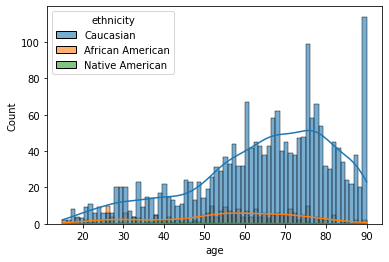

In [10]:
sns.histplot(data=df_ages, x='age', hue='ethnicity', bins=70, color='orange', kde=True, alpha=0.6)
plt.show

In [11]:
# one hot encode the ethnicity
encoder = OneHotEncoder(handle_unknown='ignore')
encoder_df = pd.DataFrame(encoder.fit_transform(df_ages[['ethnicity']]).toarray())

#merge one-hot encoded columns back with original DataFrame
final_df = df_ages.join(encoder_df)
final_df.columns = ['age', 'ethnicity', 'African American', 'Caucasian', 'Native American']
final_df.tail()

,age,ethnicity,African American,Caucasian,Native American
2248,62,Caucasian,0.0,1.0,0.0
2249,41,African American,1.0,0.0,0.0
2250,41,African American,1.0,0.0,0.0
2251,72,Caucasian,0.0,1.0,0.0
2252,50,Caucasian,0.0,1.0,0.0


In [12]:
df_ages.groupby('ethnicity').describe()

age                                                     
                   count       mean        std   min    25%   50%   75%   max
ethnicity                                                                    
African American   231.0  56.151515  16.861546  19.0  46.50  58.0  69.0  90.0
Caucasian         2010.0  64.443781  17.419489  15.0  55.00  67.0  78.0  89.0
Native American     12.0  50.500000  20.331346  19.0  39.25  48.0  66.0  88.0

## Plan
1. Create the kde for each unit type (class)
2. Sample from the kde on each training round per class
    1. sample the same number of points as we have per class (e.g. 65 samples from the CSICU class)
3. instead of training valid and fake spearately - intermingle and train together

### Build GAN, compile, and fit to the data

In [13]:
cgan = ConditionalGAN(noise_dim=50,
                 data_shape=1,
                 num_classes=3, 
                 d_learning_rate=1e-6, 
                 g_learning_rate=1e-6, 
                 batch_size=32, 
                 start_epoch=0,
                 verbose = True)

Generator input dim:  53
Dicrimination input dim:  4
Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense (Dense)               (None, 64)                320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64)                0         
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64)                0         
                                                                 


In [14]:
cgan.compile(loss_fn=keras.losses.BinaryCrossentropy(from_logits=True))

In [ ]:
cgan.fit(dataset, epochs=10000, verbose=1)

Epoch 1/10000
age_one_hot_labels1: Tensor("strided_slice_1:0", shape=(None, 1, 3), dtype=float32)
age_one_hot_labels2: Tensor("strided_slice_2:0", shape=(None,), dtype=float32)
age_one_hot_labels3: Tensor("strided_slice_3:0", shape=(None, 3), dtype=float32)


/usr/local/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


age_one_hot_labels1: Tensor("strided_slice_1:0", shape=(None, 1, 3), dtype=float32)
age_one_hot_labels2: Tensor("strided_slice_2:0", shape=(None,), dtype=float32)
age_one_hot_labels3: Tensor("strided_slice_3:0", shape=(None, 3), dtype=float32)
36/36 [==============================] - 3s 3ms/step - g_loss: 0.6608 - d_loss: 0.6913
Epoch 2/10000
36/36 [==============================] - 0s 3ms/step - g_loss: 0.6607 - d_loss: 0.6912
Epoch 3/10000
36/36 [==============================] - 0s 3ms/step - g_loss: 0.6610 - d_loss: 0.6910
Epoch 4/10000
36/36 [==============================] - 0s 3ms/step - g_loss: 0.6612 - d_loss: 0.6910
Epoch 5/10000
36/36 [==============================] - 0s 3ms/step - g_loss: 0.6612 - d_loss: 0.6908
Epoch 6/10000
36/36 [==============================] - 0s 3ms/step - g_loss: 0.6614 - d_loss: 0.6906
Epoch 7/10000
36/36 [==============================] - 0s 3ms/step - g_loss: 0.6618 - d_loss: 0.6906
Epoch 8/10000
36/36 [==============================] - 0s 3ms/s

### Generate data and save

In [ ]:
df_age_eth = pd.DataFrame(columns = ['age', 'ethnicity']) # blank DF to hold output

In [ ]:
df_age_eth # see blank DF

In [ ]:
"""Generate n ages for a class"""
print("Generating: ", 231, " ages for unit type: [1., 0., 0.]")

age_one_hot_labels = tf.repeat([[1., 0., 0.]],231, axis=0)

input_noise = tf.random.normal((231, cgan.noise_dim), 0, 1)
random_vector_labels = tf.concat([input_noise, age_one_hot_labels], axis=1)

ages = cgan.generator(random_vector_labels)

inv_gen_ages = [(val * (max_age_filtered-min_age_filtered)) + min_age_filtered for val in ages.numpy().flatten()]

print("Generated Ages:")
print("min: ", np.min(inv_gen_ages))
print("mean: ", np.mean(inv_gen_ages))
print("max: ", np.max(inv_gen_ages))
print("stdv: ", np.std(inv_gen_ages))

df_ages_class = final_df.query("ethnicity == 'African American'")

print("True Ages:")
print("min: ", np.min(df_ages_class.age))
print("mean: ", np.mean(df_ages_class.age))
print("max: ", np.max(df_ages_class.age))
print("stdv: ", np.std(df_ages_class.age))


sns.histplot(inv_gen_ages, bins=70, label='GAN', kde=True,)
sns.histplot(df_ages_class.age, bins=70, color='orange', label='Truth', alpha=0.3, kde=True,)
plt.title('African American Ages')
plt.legend()
plt.show

df_temp = pd.DataFrame(columns = ['age', 'ethnicity'])

df_temp['age'] = inv_gen_ages
df_temp['ethnicity'] = 'African American'

df_age_eth = df_age_eth.append(df_temp)

In [ ]:
"""Generate n ages for a class"""
print("Generating: ", 2010, " ages for unit type: [0., 1., 0.]")

age_one_hot_labels = tf.repeat([[0., 1., 0.]],2010, axis=0)

input_noise = tf.random.normal((2010, cgan.noise_dim), 0, 1)
random_vector_labels = tf.concat([input_noise, age_one_hot_labels], axis=1)

ages = cgan.generator(random_vector_labels)

inv_gen_ages = [(val * (max_age_filtered-min_age_filtered)) + min_age_filtered for val in ages.numpy().flatten()]

print("Generated Ages:")
print("min: ", np.min(inv_gen_ages))
print("mean: ", np.mean(inv_gen_ages))
print("max: ", np.max(inv_gen_ages))
print("stdv: ", np.std(inv_gen_ages))

df_ages_class = final_df.query("ethnicity == 'Caucasian'")

print("True Ages:")
print("min: ", np.min(df_ages_class.age))
print("mean: ", np.mean(df_ages_class.age))
print("max: ", np.max(df_ages_class.age))
print("stdv: ", np.std(df_ages_class.age))


sns.histplot(inv_gen_ages, bins=70, label='GAN', kde=True,)
sns.histplot(df_ages_class.age, bins=70, color='orange', label='Truth', alpha=0.3, kde=True,)
plt.title('Caucasian Ages')
plt.legend()
plt.show

df_temp = pd.DataFrame(columns = ['age', 'ethnicity'])

df_temp['age'] = inv_gen_ages
df_temp['ethnicity'] = 'Caucasian'

df_age_eth = df_age_eth.append(df_temp)

In [ ]:
df_ages.groupby('ethnicity').describe()

In [ ]:
"""Generate n ages for a class"""
print("Generating: ", 12, " ages for unit type: [0., 0., 1]")

age_one_hot_labels = tf.repeat([[0., 0., 1.]],12, axis=0)

input_noise = tf.random.normal((12, cgan.noise_dim), 0, 1)
random_vector_labels = tf.concat([input_noise, age_one_hot_labels], axis=1)

ages = cgan.generator(random_vector_labels)

inv_gen_ages = [(val * (max_age_filtered-min_age_filtered)) + min_age_filtered for val in ages.numpy().flatten()]

print("Generated Ages:")
print("min: ", np.min(inv_gen_ages))
print("mean: ", np.mean(inv_gen_ages))
print("max: ", np.max(inv_gen_ages))
print("stdv: ", np.std(inv_gen_ages))

df_ages_class = final_df.query("ethnicity == 'Native American'")

print("True Ages:")
print("min: ", np.min(df_ages_class.age))
print("mean: ", np.mean(df_ages_class.age))
print("max: ", np.max(df_ages_class.age))
print("stdv: ", np.std(df_ages_class.age))


sns.histplot(inv_gen_ages, bins=70, label='GAN', kde=True,)
sns.histplot(df_ages_class.age, bins=70, color='orange', label='Truth', alpha=0.3, kde=True,)
plt.title('Native American Ages')
plt.legend()
plt.show

df_temp = pd.DataFrame(columns = ['age', 'ethnicity'])

df_temp['age'] = inv_gen_ages
df_temp['ethnicity'] = 'Native American'

df_age_eth = df_age_eth.append(df_temp)

### **Evaluation**

In [ ]:
df_age_eth['data'] = 'GAN'

In [15]:
!pip install table_evaluator

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [16]:
#https://pypi.org/project/table-evaluator/
from table_evaluator import load_data, TableEvaluator


In [ ]:
final_df.head()

In [ ]:
final_df['data'] = 'Truth'

In [ ]:
df_true = final_df[['age', 'ethnicity']]

In [ ]:
df_all = final_df[['age', 'ethnicity', 'data']].append(df_age_eth).reset_index(level = 0).drop('index', axis = 1)

In [ ]:
table_evaluator = TableEvaluator(df_all[df_all['data'] == 'Truth'][['age', 'ethnicity']], df_all[df_all['data'] == 'GAN'][['age', 'ethnicity']], cat_cols=['ethnicity'])

In [ ]:
table_evaluator.evaluate(target_col='ethnicity')

In [ ]:
df_all.to_csv('age_eth_output_19APR.csv')

In [ ]:
table_evaluator.visual_evaluation()

### **Distributed Model**
https://www.tensorflow.org/tutorials/distribute/custom_training

In [17]:
mirrored_strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(mirrored_strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2


In [18]:
# Create a checkpoint directory to store the checkpoints.
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

In [19]:
#with mirrored_strategy.scope():
dist_gan = ConditionalGAN(noise_dim=50,
                 data_shape=1,
                 num_classes=3, 
                 d_learning_rate=1e-6, 
                 g_learning_rate=1e-6, 
                 batch_size=32, 
                 start_epoch=0,
                 verbose = True, distribute = 'D') # added the distributed flag in the CGAN class

  #loss_obj = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
  #loss = tf.reduce_sum(loss_obj(labels, predictions)) * (1. / global_batch_size)

dist_gan.compile(loss_fn=keras.losses.BinaryCrossentropy(from_logits=True))

Generator input dim:  53
Dicrimination input dim:  4
Instructions for updating:
use distribute.MultiWorkerMirroredStrategy instead
INFO:tensorflow:Single-worker MultiWorkerMirroredStrategy with local_devices = ('/device:GPU:0', '/device:GPU:1'), communication = CommunicationImplementation.AUTO
Number of devices: 2
Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_6 (Dense)             (None, 64)                320       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 64)                0         
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 

In [20]:
dist_gan.fit(dataset, epochs=10000, verbose=1)

Epoch 1/10000
age_one_hot_labels1: Tensor("strided_slice_1:0", shape=(None, 1, 3), dtype=float32)
age_one_hot_labels2: Tensor("strided_slice_2:0", shape=(None,), dtype=float32)
age_one_hot_labels3: Tensor("strided_slice_3:0", shape=(None, 3), dtype=float32)


/usr/local/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


age_one_hot_labels1: Tensor("strided_slice_1:0", shape=(None, 1, 3), dtype=float32)
age_one_hot_labels2: Tensor("strided_slice_2:0", shape=(None,), dtype=float32)
age_one_hot_labels3: Tensor("strided_slice_3:0", shape=(None, 3), dtype=float32)
36/36 [==============================] - 3s 3ms/step - g_loss: 0.7128 - d_loss: 0.6907
Epoch 2/10000
36/36 [==============================] - 0s 3ms/step - g_loss: 0.7123 - d_loss: 0.6905
Epoch 3/10000
36/36 [==============================] - 0s 3ms/step - g_loss: 0.7118 - d_loss: 0.6904
Epoch 4/10000
36/36 [==============================] - 0s 3ms/step - g_loss: 0.7112 - d_loss: 0.6902
Epoch 5/10000
36/36 [==============================] - 0s 3ms/step - g_loss: 0.7106 - d_loss: 0.6901
Epoch 6/10000
36/36 [==============================] - 0s 3ms/step - g_loss: 0.7101 - d_loss: 0.6900
Epoch 7/10000
36/36 [==============================] - 0s 3ms/step - g_loss: 0.7098 - d_loss: 0.6899
Epoch 8/10000
36/36 [==============================] - 0s 3ms/s

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



36/36 [==============================] - 0s 3ms/step - g_loss: 0.6931 - d_loss: 0.6933
Epoch 8286/10000
36/36 [==============================] - 0s 3ms/step - g_loss: 0.6929 - d_loss: 0.6932
Epoch 8287/10000
36/36 [==============================] - 0s 3ms/step - g_loss: 0.6929 - d_loss: 0.6934
Epoch 8288/10000
36/36 [==============================] - 0s 3ms/step - g_loss: 0.6932 - d_loss: 0.6934
Epoch 8289/10000
36/36 [==============================] - 0s 3ms/step - g_loss: 0.6930 - d_loss: 0.6932
Epoch 8290/10000
36/36 [==============================] - 0s 3ms/step - g_loss: 0.6932 - d_loss: 0.6933
Epoch 8291/10000
36/36 [==============================] - 0s 3ms/step - g_loss: 0.6929 - d_loss: 0.6933
Epoch 8292/10000
36/36 [==============================] - 0s 3ms/step - g_loss: 0.6933 - d_loss: 0.6932
Epoch 8293/10000
36/36 [==============================] - 0s 3ms/step - g_loss: 0.6929 - d_loss: 0.6933
Epoch 8294/10000
36/36 [==============================] - 0s 3ms/step - g_loss: 0

In [21]:
dist_age_eth = pd.DataFrame(
    columns = ['age', 'ethnicity'])

In [22]:
dist_age_eth

,age,ethnicity


In [23]:
dist_age_eth

,age,ethnicity


Generating:  231  ages for unit type: [1., 0., 0.]
Generated Ages:
min:  16.162719320505857
mean:  56.6920737613686
max:  79.39950907230377
stdv:  14.010461163569309
True Ages:
min:  19
mean:  56.15151515151515
max:  90
stdv:  16.825009339158104


/tmp/ipykernel_19513/1292840024.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dist_age_eth = dist_age_eth.append(df_temp)


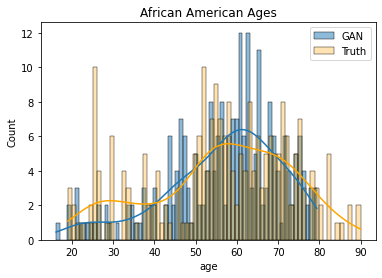

In [24]:
"""Generate n ages for a class"""
print("Generating: ", 231, " ages for unit type: [1., 0., 0.]")

age_one_hot_labels = tf.repeat([[1., 0., 0.]],231, axis=0)

input_noise = tf.random.normal((231, dist_gan.noise_dim), 0, 1)
random_vector_labels = tf.concat([input_noise, age_one_hot_labels], axis=1)

ages = dist_gan.generator(random_vector_labels)

inv_gen_ages = [(val * (max_age_filtered-min_age_filtered)) + min_age_filtered for val in ages.numpy().flatten()]

print("Generated Ages:")
print("min: ", np.min(inv_gen_ages))
print("mean: ", np.mean(inv_gen_ages))
print("max: ", np.max(inv_gen_ages))
print("stdv: ", np.std(inv_gen_ages))

df_ages_class = final_df.query("ethnicity == 'African American'")

print("True Ages:")
print("min: ", np.min(df_ages_class.age))
print("mean: ", np.mean(df_ages_class.age))
print("max: ", np.max(df_ages_class.age))
print("stdv: ", np.std(df_ages_class.age))


sns.histplot(inv_gen_ages, bins=70, label='GAN', kde=True,)
sns.histplot(df_ages_class.age, bins=70, color='orange', label='Truth', alpha=0.3, kde=True,)
plt.title('African American Ages')
plt.legend()
plt.show

df_temp = pd.DataFrame(columns = ['age', 'ethnicity'])

df_temp['age'] = inv_gen_ages
df_temp['ethnicity'] = 'African American'

dist_age_eth = dist_age_eth.append(df_temp)

Generating:  2010  ages for unit type: [0., 1., 0.]
Generated Ages:
min:  15.19424419105053
mean:  64.74418504808321
max:  87.99512672424316
stdv:  18.24123112471617
True Ages:
min:  15
mean:  64.44378109452737
max:  89
stdv:  17.415155338226757


/tmp/ipykernel_19513/2109511226.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dist_age_eth = dist_age_eth.append(df_temp)


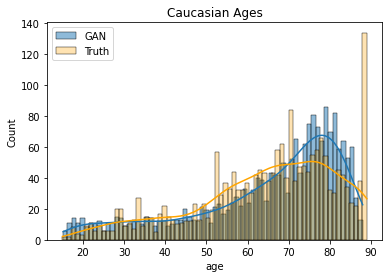

In [25]:
"""Generate n ages for a class"""
print("Generating: ", 2010, " ages for unit type: [0., 1., 0.]")

age_one_hot_labels = tf.repeat([[0., 1., 0.]],2010, axis=0)

input_noise = tf.random.normal((2010, dist_gan.noise_dim), 0, 1)
random_vector_labels = tf.concat([input_noise, age_one_hot_labels], axis=1)

ages = dist_gan.generator(random_vector_labels)

inv_gen_ages = [(val * (max_age_filtered-min_age_filtered)) + min_age_filtered for val in ages.numpy().flatten()]

print("Generated Ages:")
print("min: ", np.min(inv_gen_ages))
print("mean: ", np.mean(inv_gen_ages))
print("max: ", np.max(inv_gen_ages))
print("stdv: ", np.std(inv_gen_ages))

df_ages_class = final_df.query("ethnicity == 'Caucasian'")

print("True Ages:")
print("min: ", np.min(df_ages_class.age))
print("mean: ", np.mean(df_ages_class.age))
print("max: ", np.max(df_ages_class.age))
print("stdv: ", np.std(df_ages_class.age))


sns.histplot(inv_gen_ages, bins=70, label='GAN', kde=True,)
sns.histplot(df_ages_class.age, bins=70, color='orange', label='Truth', alpha=0.3, kde=True,)
plt.title('Caucasian Ages')
plt.legend()
plt.show

df_temp = pd.DataFrame(columns = ['age', 'ethnicity'])

df_temp['age'] = inv_gen_ages
df_temp['ethnicity'] = 'Caucasian'

dist_age_eth = dist_age_eth.append(df_temp)

In [26]:
df_ages.groupby('ethnicity').describe()

age                                                     
                   count       mean        std   min    25%   50%   75%   max
ethnicity                                                                    
African American   231.0  56.151515  16.861546  19.0  46.50  58.0  69.0  90.0
Caucasian         2010.0  64.443781  17.419489  15.0  55.00  67.0  78.0  89.0
Native American     12.0  50.500000  20.331346  19.0  39.25  48.0  66.0  88.0

Generating:  12  ages for unit type: [0., 0., 1]
Generated Ages:
min:  26.527655124664307
mean:  49.73679373661677
max:  78.26466882228851
stdv:  16.290878687834166
True Ages:
min:  19
mean:  50.5
max:  88
stdv:  19.465781943365815


/tmp/ipykernel_19513/1058641000.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dist_age_eth = dist_age_eth.append(df_temp)


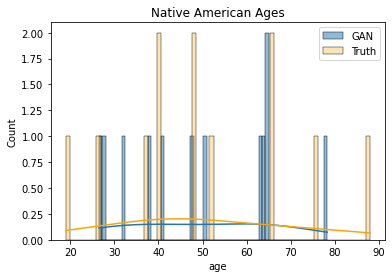

In [27]:
"""Generate n ages for a class"""
print("Generating: ", 12, " ages for unit type: [0., 0., 1]")

age_one_hot_labels = tf.repeat([[0., 0., 1.]],12, axis=0)

input_noise = tf.random.normal((12, dist_gan.noise_dim), 0, 1)
random_vector_labels = tf.concat([input_noise, age_one_hot_labels], axis=1)

ages = dist_gan.generator(random_vector_labels)

inv_gen_ages = [(val * (max_age_filtered-min_age_filtered)) + min_age_filtered for val in ages.numpy().flatten()]

print("Generated Ages:")
print("min: ", np.min(inv_gen_ages))
print("mean: ", np.mean(inv_gen_ages))
print("max: ", np.max(inv_gen_ages))
print("stdv: ", np.std(inv_gen_ages))

df_ages_class = final_df.query("ethnicity == 'Native American'")

print("True Ages:")
print("min: ", np.min(df_ages_class.age))
print("mean: ", np.mean(df_ages_class.age))
print("max: ", np.max(df_ages_class.age))
print("stdv: ", np.std(df_ages_class.age))


sns.histplot(inv_gen_ages, bins=70, label='GAN', kde=True,)
sns.histplot(df_ages_class.age, bins=70, color='orange', label='Truth', alpha=0.3, kde=True,)
plt.title('Native American Ages')
plt.legend()
plt.show

df_temp = pd.DataFrame(columns = ['age', 'ethnicity'])

df_temp['age'] = inv_gen_ages
df_temp['ethnicity'] = 'Native American'

dist_age_eth = dist_age_eth.append(df_temp)

**Evaluation**

In [28]:
dist_age_eth['data'] = 'GAN'

In [29]:
!pip install table_evaluator

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [30]:
#https://pypi.org/project/table-evaluator/
from table_evaluator import load_data, TableEvaluator


In [31]:
final_df.head()

,age,ethnicity,African American,Caucasian,Native American
0,87,Caucasian,0.0,1.0,0.0
1,87,Caucasian,0.0,1.0,0.0
2,76,Caucasian,0.0,1.0,0.0
3,34,Caucasian,0.0,1.0,0.0
4,61,Caucasian,0.0,1.0,0.0


In [32]:
final_df['data'] = 'Truth'

In [33]:
df_true = final_df[['age', 'ethnicity']].reset_index().drop('index', axis = True)

In [34]:
dist_age_eth.reset_index(level = 0, inplace = True)

In [35]:
dist_age_eth[['age', 'ethnicity']].head()

,age,ethnicity
0,64.851381,African American
1,46.723606,African American
2,64.056428,African American
3,62.048296,African American
4,56.075915,African American


In [36]:
df_true.head()

,age,ethnicity
0,87,Caucasian
1,87,Caucasian
2,76,Caucasian
3,34,Caucasian
4,61,Caucasian


In [37]:
dist_age_eth.drop('index', axis = 1).head()

,age,ethnicity,data
0,64.851381,African American,GAN
1,46.723606,African American,GAN
2,64.056428,African American,GAN
3,62.048296,African American,GAN
4,56.075915,African American,GAN


In [38]:
df_all = final_df[['age', 'ethnicity', 'data']].append(dist_age_eth.drop('index', axis = 1)).reset_index(level = 0).drop('index', axis = 1)

/tmp/ipykernel_19513/1869240132.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all = final_df[['age', 'ethnicity', 'data']].append(dist_age_eth.drop('index', axis = 1)).reset_index(level = 0).drop('index', axis = 1)


In [39]:
df_all.head()

,age,ethnicity,data
0,87,Caucasian,Truth
1,87,Caucasian,Truth
2,76,Caucasian,Truth
3,34,Caucasian,Truth
4,61,Caucasian,Truth


In [40]:
table_evaluator = TableEvaluator(df_all[df_all['data'] == 'Truth'][['age', 'ethnicity']], df_all[df_all['data'] == 'GAN'][['age', 'ethnicity']], cat_cols=['ethnicity'])

In [41]:
table_evaluator.evaluate(target_col='ethnicity')

/usr/local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())



Classifier F1-scores and their Jaccard similarities::
                             f1_real  f1_fake  jaccard_similarity
index                                                            
DecisionTreeClassifier_fake   0.8803   0.8271              0.7826
DecisionTreeClassifier_real   0.8736   0.8293              0.8222
LogisticRegression_fake       0.8958   0.8958              1.0000
LogisticRegression_real       0.8758   0.8758              1.0000
MLPClassifier_fake            0.8958   0.8958              1.0000
MLPClassifier_real            0.8758   0.8758              1.0000
RandomForestClassifier_fake   0.8780   0.8248              0.7721
RandomForestClassifier_real   0.8714   0.8204              0.7968

Privacy results:
                                            result
Duplicate rows between sets (real/fake)  (2232, 0)
nearest neighbor mean                       0.0104
nearest neighbor std                        0.0396

Miscellaneous results:
                                  Resul

In [42]:
#dist_age_eth[['age', 'ethnicity']].reset_index().drop('index', axis = True).index.is_unique

In [43]:
df_all.append(df_all).to_csv('dist_age_eth_discrim_19APR.csv')

/tmp/ipykernel_19513/3868567086.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all.append(df_all).to_csv('dist_age_eth_discrim_19APR.csv')


In [44]:
#dist_age_eth[['age', 'ethnicity']].reset_index(level = 0, inplace = True)#.drop('index', axis = True)

In [45]:
dist_age_eth[['age', 'ethnicity']][dist_age_eth[['age', 'ethnicity']].index.duplicated()]

,age,ethnicity


In [46]:
df_true[df_true.index.duplicated()]

,age,ethnicity


In [47]:
df_all.head()

,age,ethnicity,data
0,87,Caucasian,Truth
1,87,Caucasian,Truth
2,76,Caucasian,Truth
3,34,Caucasian,Truth
4,61,Caucasian,Truth


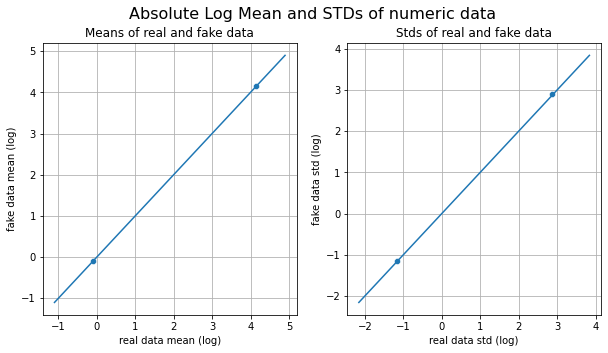

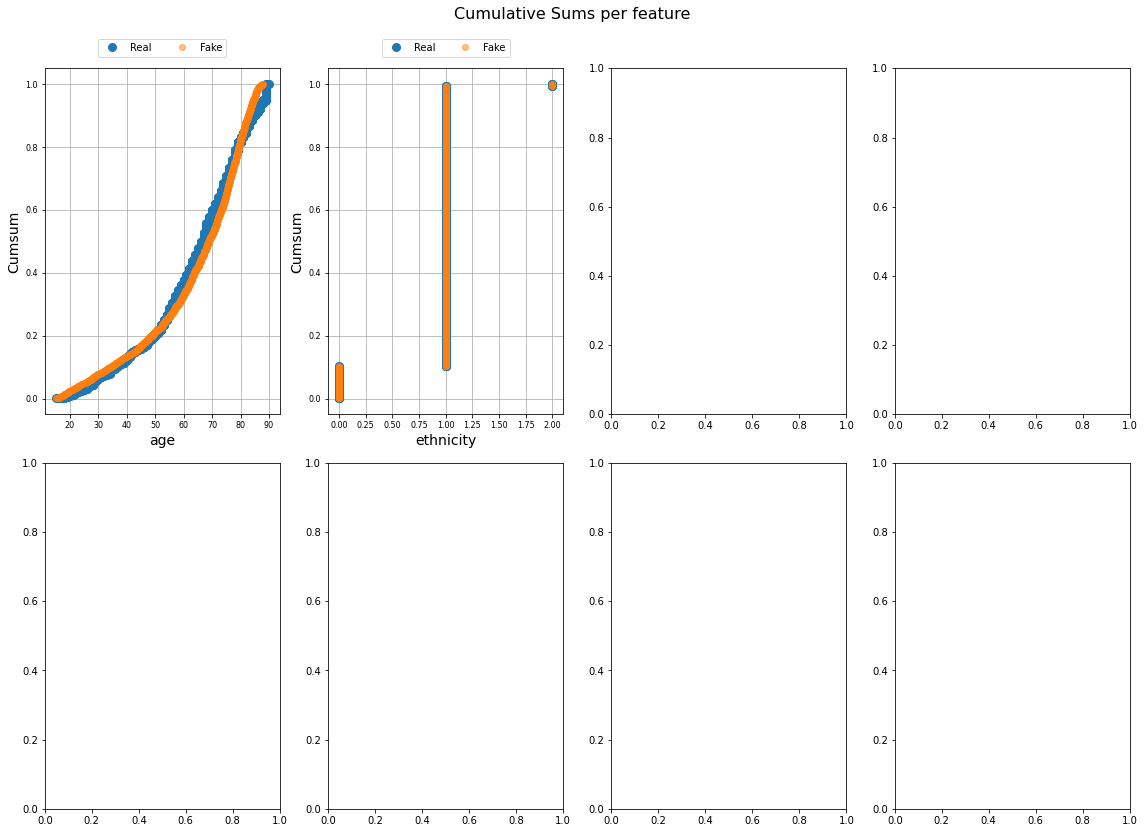

/home/dmf4ns/.local/lib/python3.9/site-packages/table_evaluator/table_evaluator.py:156: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plot_df = pd.DataFrame({col: self.real[col].append(self.fake[col]), 'kind': ['real'] * self.n_samples + ['fake'] * self.n_samples})


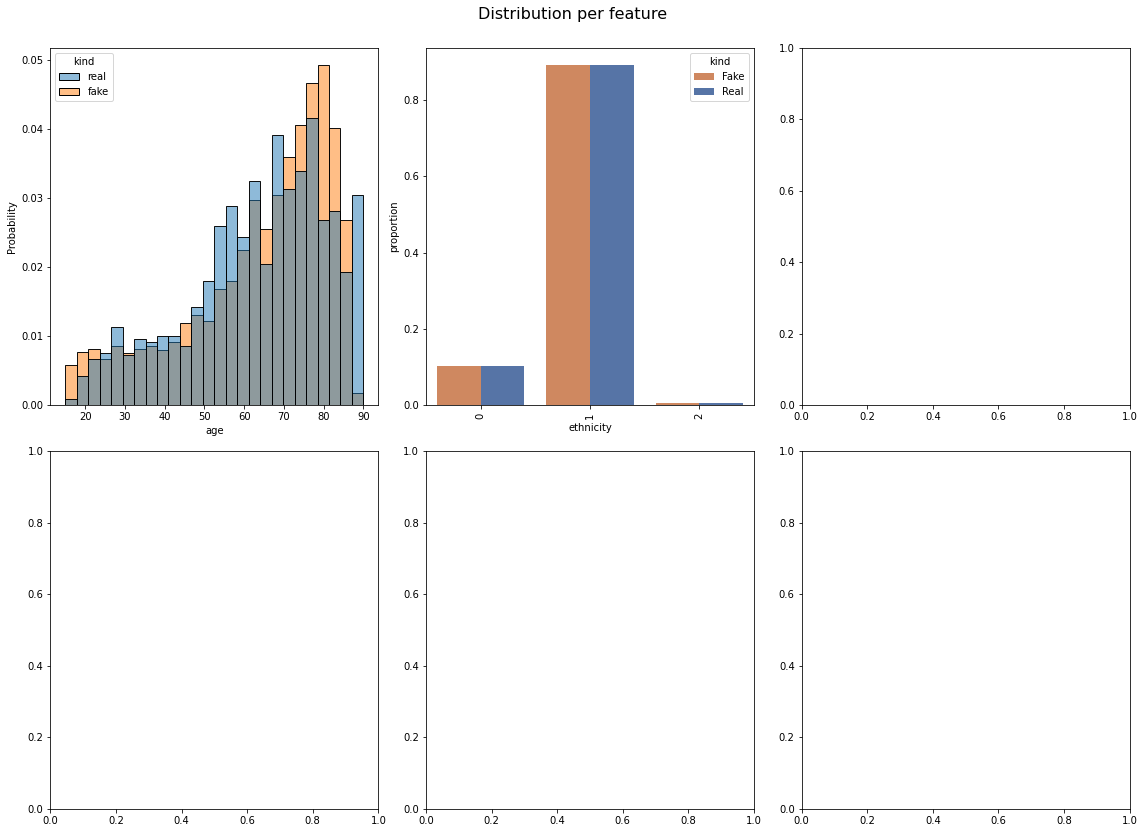

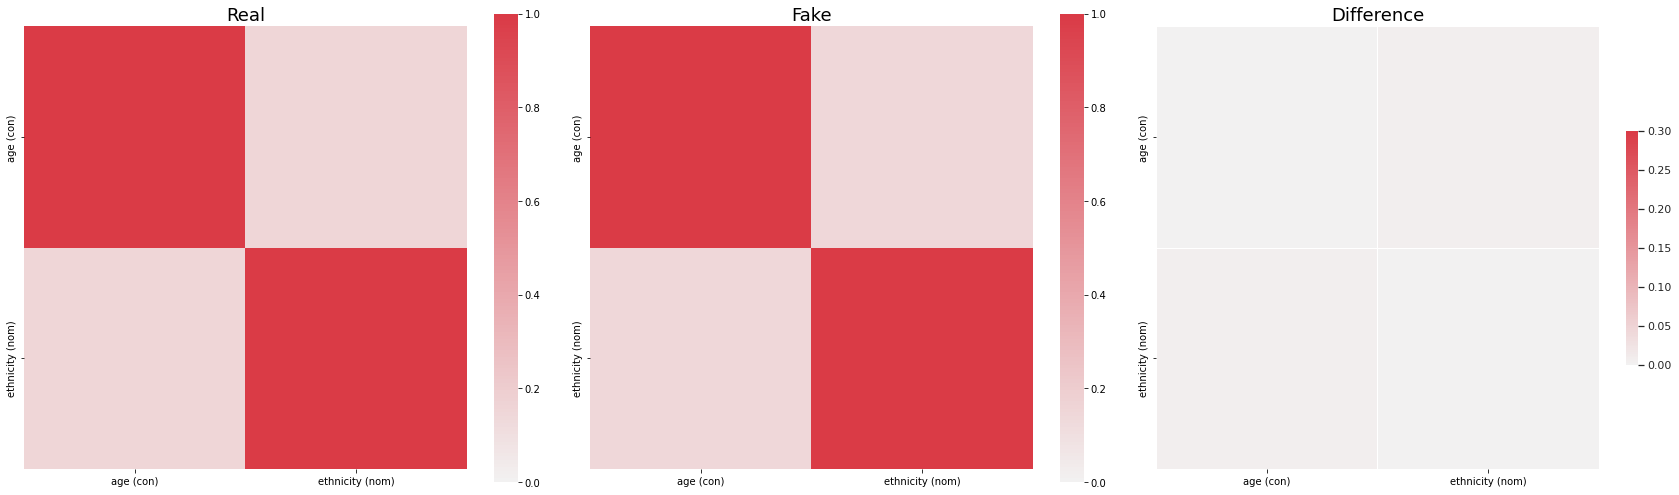

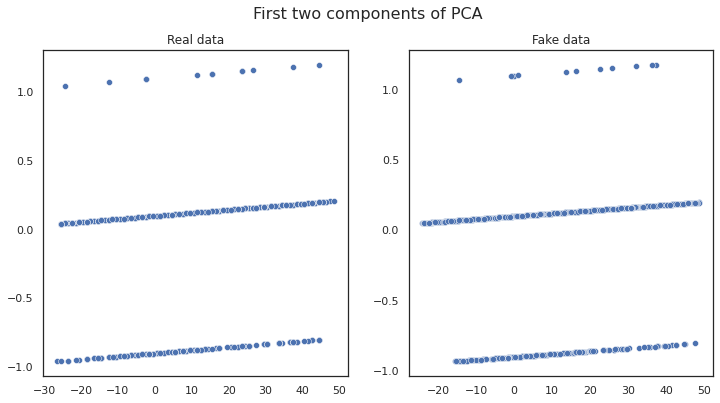

In [48]:
table_evaluator.visual_evaluation()